# CA3 - Eirik Høyheim

## Imports and reading of data

In [2]:
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [5]:
train_raw = pd.read_csv("datasets/train.csv", index_col=0)
test_raw = pd.read_csv("datasets/test.csv", index_col=0)

## Visualization

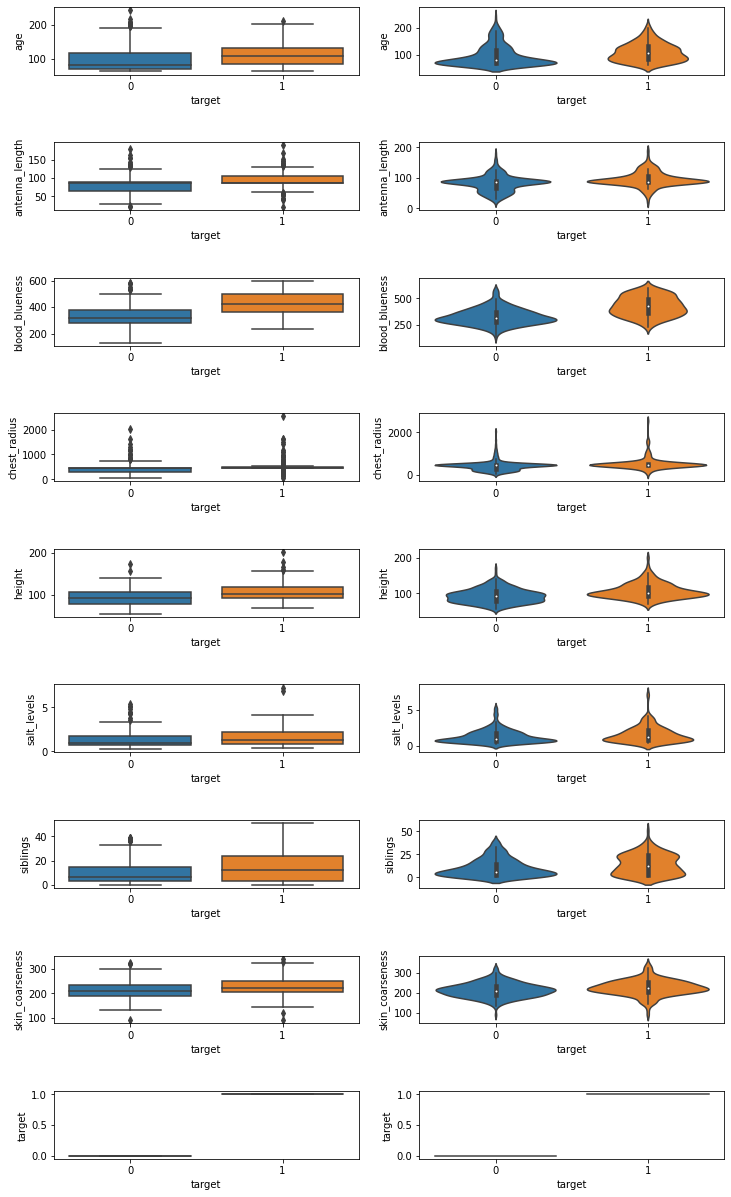

In [9]:
columns = train_raw.columns  # all columns in train_raw
fig, ax = plt.subplots(len(columns), 2, figsize=(12,20))  # prepairs subplots for all columns
plt.subplots_adjust(bottom=.2, top=1, hspace=1)
for index, col in enumerate(columns):
    sns.boxplot(ax=ax[index, 0], y=train_raw[col], x=train_raw["target"])  # plots a boxplot for all columns with seperation on targets
    sns.violinplot(ax=ax[index, 1], data=train_raw, y=train_raw[col], x=train_raw["target"])  # plots a violin polot for all columns with seperation on targets

The first thing that I noticed from the plots was that `anthenna_length` and `chest_radius` seems to have a lot of outliers with a very "slim" mean. Other noticable things is that it seems like `blood_blueness` and `siblings` have slightly different distribution between the 0 and 1 target, when looking at the violin plot. Other than that, we may have some potential outliers in some of the other plots too that we need to considered when traning the data.  

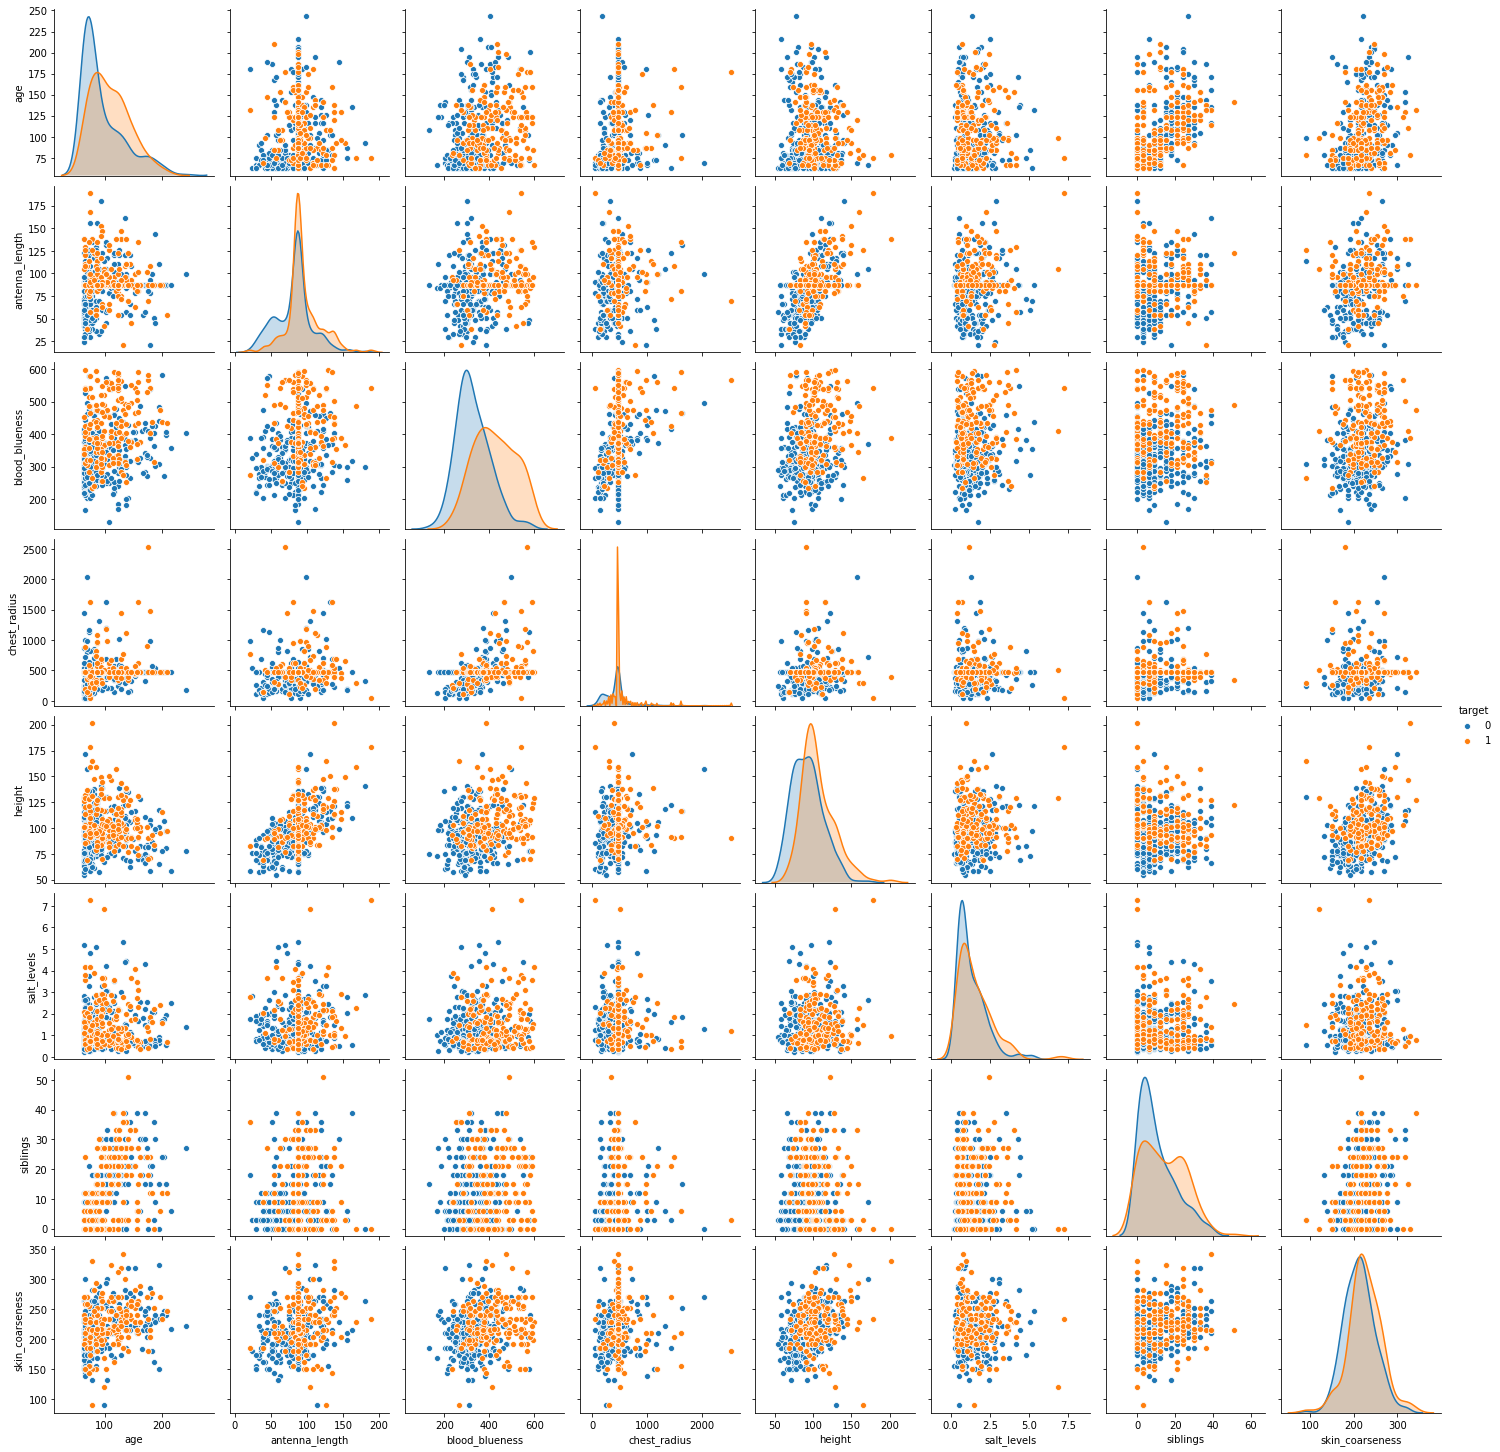

In [8]:
sns.pairplot(train_raw, hue="target")
plt.show()

As we can see in the pairplot, there is no combiantion that are linearly seperable in two-dimensions. Therefore, it would probably be a good idea to involve at least three features when training the data and mabye use an algortihm that do not seperate linearly. We can also see that some of the features are very skewed, like `siblings`, `salt_levels` and `age`, and some features that seemse fearly close to normal distributed, like `skin_coarseness` and `height`.

## Training and testing data 

Since there's so many points with the same value in chest_radius, I chose to not include them when training my data. This process will remove alot of potentially important datapoints, therefore we need to be ceareful to not overfit our training dataset. 

In [3]:
train_without_major_repetition = copy.copy(train_raw[round(train_raw["chest_radius"], 5) != 466.64467]) # keeps all rows where chest radius is not 466.64467

In [4]:
train_raw.shape, train_without_major_repetition.shape

((460, 9), (233, 9))

##### Now to the training part:

I chose to use the `RandomForestClassifier` to predict my data. I itterate through multiple combinations of min_samples_split and max_depth to get the the best average prediction accuracy as possible. 

In [5]:
X = train_without_major_repetition.iloc[:, :-1].values  # all values except targets 
y = train_without_major_repetition.iloc[:, -1].values   # all targets

test_score = {}  # saves all test scores to see what parameters preforms the best at average
train_score = {}  # saves all train scores too look for overfitting

best_min_samples_split = 0  # stores the min_samples_split that gives the best result 
best_max_depth = 0  # stores the max_depth that gives the best result
best_mean_score = 0  # saves the best average score

for min_samples_split in np.arange(30, 40, 1):  # changes the min_samples_split to reduce overfitting
    
    test_score[f"min_samples_split: {min_samples_split}"] = {}  # saves all mean scores for the different min_samples_split and max_depth
    train_score[f"min_samples_split: {min_samples_split}"] = {}
    
    for max_depth in range(4, 9):  # try to find a max_depth that gives a higher test accuracy
        test = []  # collects all scores from the different splits
        train = []
        for split in range(1, 101):
            X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.3, random_state=split, stratify=y)

            forest = RandomForestClassifier(
                criterion="gini", 
                n_estimators=100, 
                random_state=1, 
                n_jobs=-1, 
                min_samples_split=min_samples_split, 
                max_depth=max_depth) 

            forest.fit(X_train, y_train)

            test.append(forest.score(X_test, y_test))
            train.append(forest.score(X_train, y_train))
            
        
        test_score[f"min_samples_split: {min_samples_split}"][f"max_depth: {max_depth}"] = np.mean(test)  # saves the mean data from all splits with the given parameters
        train_score[f"min_samples_split: {min_samples_split}"][f"max_depth: {max_depth}"] = np.mean(train)

        if best_mean_score < np.mean(test):  # saves the min_samples_split and max_depth where the mean is at it's highest
            best_min_samples_split = min_samples_split
            best_max_depth = max_depth
            best_mean_score = np.mean(test)

In [6]:
print(f"Highest score on average: {best_mean_score}\nFound at min_sample_split: {best_min_samples_split}\nand max_depth: {best_max_depth}")

Highest score on average: 0.787142857142857
Found at min_sample_split: 36
and max_depth: 7


In [7]:
X = train_without_major_repetition.iloc[:, :-1]
y = train_without_major_repetition.iloc[:, -1]
forest = RandomForestClassifier(
    criterion="gini", n_estimators=100, random_state=1, n_jobs=-1, min_samples_split=best_min_samples_split, max_depth=best_max_depth)
forest.fit(X, y)
importance = forest.feature_importances_
for index, col in enumerate(X.columns):
    print(f"Feature {col} have importance: {round(importance[index], 4)}")

Feature age have importance: 0.149
Feature antenna_length have importance: 0.0749
Feature blood_blueness have importance: 0.3543
Feature chest_radius have importance: 0.155
Feature height have importance: 0.1265
Feature salt_levels have importance: 0.0508
Feature siblings have importance: 0.0488
Feature skin_coarseness have importance: 0.0408


blood_blueness is the most important feature and skin_coarseness, siblings and salt_levels is the least important features when predicting data. Potentially, we may want to remove the least important features to get better accuracy, but since I have already removed so many points, it may not be so wise to remove even more data. We want to avoid overfitting the data and making it a less optimal model for other, unknown datasets.

## Submission to kaggle

In [8]:
X = train_without_major_repetition.iloc[:, :-1]
y = train_without_major_repetition.iloc[:, -1]

forest = RandomForestClassifier(
    criterion="gini", n_estimators=100, random_state=1, n_jobs=-1, min_samples_split=36, max_depth=7)
forest.fit(X, y)

RandomForestClassifier(max_depth=7, min_samples_split=36, n_jobs=-1,
                       random_state=1)

In [9]:
y_predictions = forest.predict(test_raw.iloc[:, :].values)
my_submission = {"Id": [], "Predicted": []}
for pred_id, pred in enumerate(y_predictions):
    my_submission["Id"].append(pred_id)
    my_submission["Predicted"].append(pred)
    
submission_ready = pd.DataFrame(my_submission)
submission_ready.to_csv("final_submission_random_forest", index=False)

This gave me a score of $\textbf{0.74193}$ on public leaderboard on kaggle. Since the kaggle data on the public leaderboard was skewed with 0 as targets, it was hard to find a more optimal solution.

## Extra, how I got 0.92307 on public leaderboard on kaggle

This code gave me a poorer performance when testing my train data when training to find a better C value and gamma value, but when I sent it in I got 92.3% on public leaderboard. I found the C value (0.08) and gamma value (0.15) by just trying out random values. Reasoning for the high public leaderboard score may be because of overfitting, so when I predict the test dataset it will mostly predict zeros (which is what the public leaderboard consit the most of). This code did not preform well on the public leaderboard when not using the excact same features as I did in the code below.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

X = train_raw.iloc[:, [0,2,3,4,6,7]]
y = train_raw.iloc[:, -1]

sc = StandardScaler()
sc.fit(X)

X_train_sc = sc.transform(X)

svm = SVC(C=0.08, 
        kernel="rbf",
        random_state=1,
        gamma=0.15)

svm.fit(X_train_sc, y)

X_test_sc = sc.transform(test_raw.iloc[:, [0,2,3,4,6,7]])
y_predictions = svm.predict(X_test_sc)
my_submission = {"Id": [], "Predicted": []}
for pred_id, pred in enumerate(y_predictions):
    my_submission["Id"].append(pred_id)
    my_submission["Predicted"].append(pred)
    
submission_ready = pd.DataFrame(my_submission)
submission_ready.to_csv("svm_non_linear_feature_0_2_3_4_6_7", index=False)